# Try preprocessing data

In [1]:
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
import utils as ut
import pandas as pd

In [2]:
importlib.reload(dataloader)

<module 'dataloader' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\dataloader.py'>

**Load Data**

In [5]:
data_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\AnalyzedVideos\MDX5CV_DLC_analyzed\MDXCV_mal_Test 1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5'

data_dlc = dataloader.DataDLC(data_path)

TypeError: 'module' object is not callable. Did you mean: 'DataDLC.DataDLC(...)'?

In [4]:
data_dlc.preprocess()

In [5]:
data_dlc.coords.isna().sum().sum()

5305

In [6]:
prev = data_dlc.coords['individual1']['Nose']['x']

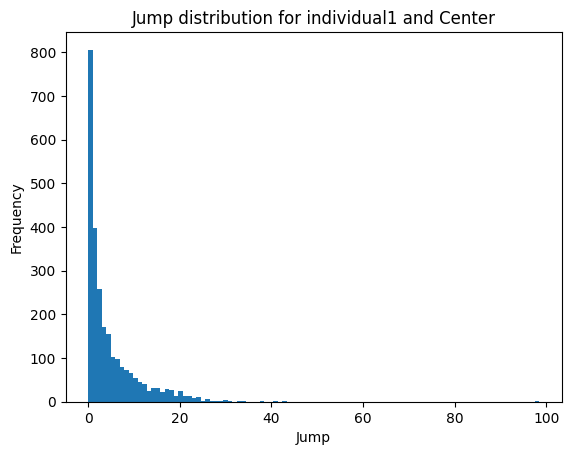

Mean of the jumps for individual1 and Center: 4.781229385008302
Standard deviation of the jumps for individual1 and Center: 6.157839272683515
min 0.0
max 98.416
mode 0    0.0
dtype: float64
median 2.3867402888512914
95 upper percentile 17.7672147949839


In [7]:
diff = data_dlc.get_statistics_on_jumps(plot = True)
print('min', diff.min())
print('max', diff.max())
print('mode', diff.mode())
print('median', diff.median())
print('95 upper percentile', diff.quantile(0.95))

In [8]:
# Deactivate warnings
pd.options.mode.chained_assignment = None  # default='warn'

data_dlc.iterative_jump_detection(threshold_hard=[10000,10000], threshold_soft_min=30, threshold_soft_max=8,  verbose=True, tol=1e-9)
#data_dlc.iterative_jump_detection(verbose=True, tol=1e-9)

  0%|          | 0/50 [00:00<?, ?it/s]

Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 3


In [9]:
# Count trues in mask_jumps
print(data_dlc.mask_jumps.sum().sum())

3


In [10]:
for ind in data_dlc.individuals:
    for part in data_dlc.body_parts:
        if data_dlc.mask_jumps[ind][part].sum() > 0:
            print('Thers a jump in individual', ind, 'part', part, 'at frames', np.where(data_dlc.mask_jumps[ind][part])[0])
        

Thers a jump in individual individual1 part Tail_tip at frames [1895]
Thers a jump in individual individual2 part Nose at frames [2201]
Thers a jump in individual individual2 part Tail_tip at frames [1555]


In [11]:
if True:
    data_dlc.remove_outlier_bouts(threshold_split_tracklets=40, threshold_jump=150, percentage_gap_neigh=0.2, verbose=True)

Outlier bout detected between 2528 and 2537  of individual individual1 and body part Tail_3
	 Jump between tracklet is 159.74469532663676
Outlier bout detected between 2538 and 2543  of individual individual1 and body part Tail_3
	 Jump between tracklet is 154.63047407610182
Outlier bout detected between 318 and 326  of individual individual1 and body part Tail_4
	 Jump between tracklet is 170.81293974989134
Outlier bout detected between 2053 and 2057  of individual individual1 and body part Tail_4
	 Jump between tracklet is 242.16096888020576
Outlier bout detected between 321 and 326  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 161.6948097188033
Outlier bout detected between 2516 and 2516  of individual individual2 and body part Tail_3
	 Jump between tracklet is 161.05367997347966
Outlier bout detected between 2529 and 2537  of individual individual2 and body part Tail_3
	 Jump between tracklet is 159.86699999999996
Outlier bout detected between 130 and

**Check out the mask_jump output**

In [12]:
import matplotlib.pyplot as plt
# Import Arima model
from statsmodels.tsa.arima.model import ARIMA

# MINIC method to detect p and q for ARIMA


In [13]:
# Fit an Arma model with the points where no jumps were detected
coords = data_dlc.coords
mask_jumps = data_dlc.mask_jumps
# Mask_jumps has true where jumps were detected
mask_no_jumps = ~mask_jumps

# Try with 'Nose' x coordinate of 'individual2'
x_time_serie_nose_no_jumps = coords['individual2']['Nose']['x'][mask_no_jumps['individual2']['Nose']]
x_time_serie_nose_imputed = coords['individual2']['Nose']['x'][mask_jumps['individual2']['Nose']]
y_time_serie_nose_no_jumps = coords['individual2']['Nose']['y'][mask_no_jumps['individual2']['Nose']]
x_time_serie_nose_jumps = prev[mask_jumps['individual2']['Nose']]
y_time_serie_nose_jumps = prev[mask_jumps['individual2']['Nose']]



c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


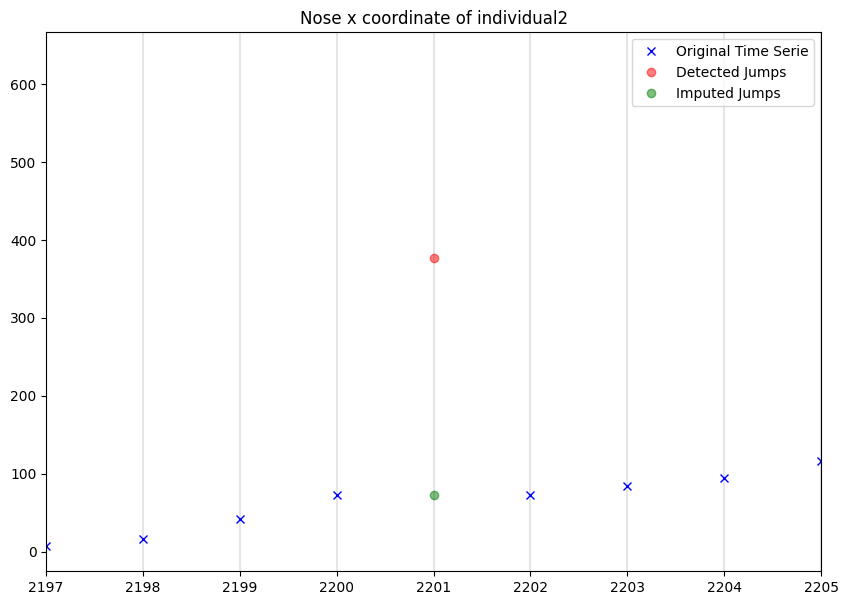

In [14]:
# plot the time series
plt.figure(figsize=(10, 7))
plt.plot(x_time_serie_nose_no_jumps, color='blue', marker='x', linestyle='', label='Original Time Serie')
plt.plot(x_time_serie_nose_jumps, color='red', linestyle='', marker='o', alpha=0.5, label='Detected Jumps')
plt.plot(x_time_serie_nose_imputed, color='green', linestyle='', marker='o', alpha=0.5, label='Imputed Jumps')
# plot lines at each frame
for i in range(len(x_time_serie_nose_no_jumps)):
    plt.axvline(x=i, color='black', alpha=0.1)
plt.xlim(2197, 2205)
plt.legend()
plt.title('Nose x coordinate of individual2')
plt.show()


In [15]:
x_time_serie_nose_jumps

2201    376.833
Name: x, dtype: float64

In [16]:
# Fit an ARIMA model
ARIMA_model = ARIMA(x_time_serie_nose_no_jumps, order=(1,1,1))
ARIMA_model_fit = ARIMA_model.fit()
ARIMA_model_fit.summary()


c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Usuario\anaconda3\envs\deepof\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                 2623
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8950.961
Date:                Thu, 22 Aug 2024   AIC                          17907.922
Time:                        10:01:38   BIC                          17925.537
Sample:                             0   HQIC                         17914.301
                               - 2623                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8102      0.013     62.488      0.000       0.785       0.836
ma.L1         -0.2368      0.016    -14.851      0.000      -0.268      -0.206
sigma2        64.1427      0.544    117.928      0.000      63.077      65.209
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             53873.55
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# Try with 'Tail_3' x coordinate of 'individual1'
x_time_serie_Tail_3_no_jumps = coords['individual1']['Tail_3']['x'][mask_no_jumps['individual1']['Tail_3']]
x_time_serie_Tail_3_imputed = coords['individual1']['Tail_3']['x'][mask_jumps['individual1']['Tail_3']]
y_time_serie_Tail_3_no_jumps = coords['individual1']['Tail_3']['y'][mask_no_jumps['individual1']['Tail_3']]
x_time_serie_Tail_3_jumps = prev[mask_jumps['individual1']['Tail_3']]
y_time_serie_Tail_3_jumps = prev[mask_jumps['individual1']['Tail_3']]


In [18]:
x_time_serie_Tail_3_jumps

2528    256.407
2529    264.510
2530    264.510
2531        NaN
2532        NaN
2533    264.510
2534    261.983
2535    264.677
2536    260.097
2537    255.617
2538    255.569
2539    254.185
2540    252.390
2541    243.006
2542    241.582
2543    240.007
Name: x, dtype: float64

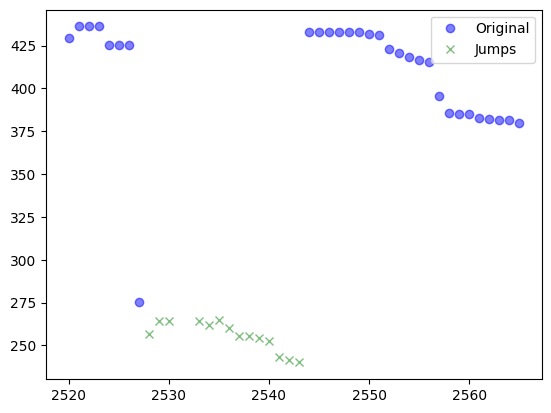

In [19]:
# Plot fitted values603 and 606
plt.plot(x_time_serie_Tail_3_no_jumps[2520:2550], color='blue', label='Original', marker = 'o', linestyle='None', alpha=0.5)
plt.plot(x_time_serie_Tail_3_jumps, color='green', label='Jumps', marker = 'x', linestyle='None', alpha=0.5)
#plt.plot(ARIMA_model_fit.fittedvalues[700:720], color='red', linestyle='--', label='Fitted')
plt.legend()
plt.show()



In [20]:
ARIMA_model_fit.fittedvalues

0         0.000000
1       511.078211
2       515.223555
3       514.168022
4       513.793124
           ...    
2619    507.598824
2620    508.188362
2621    507.378567
2622    516.885784
2623    513.972241
Length: 2623, dtype: float64

In [21]:
data_dlc.coords['individual2']['Left_ear']['x'].iloc[10:30]

10    420.038
11    392.055
12    353.992
13    330.081
14    312.031
15    305.814
16    300.652
17    300.646
18    300.443
19    300.438
20    300.438
21    300.438
22    300.438
23    300.438
24    200.973
25    175.392
26    160.942
27    155.303
28    154.776
29    154.776
Name: x, dtype: float64

In [22]:
data_dlc.coords.isna().sum().sum()

5641

In [23]:
data_dlc.coords.head(300)

individuals individual1                                                   \
bodyparts          Nose                     Left_ear                       
coords                x        y likelihood        x        y likelihood   
0               217.172  182.327        1.0  248.558  198.764        1.0   
1               217.172  183.464        1.0  248.558  200.210        1.0   
2               217.172  183.911        1.0  248.558  200.210        1.0   
3               210.524  183.911        1.0  238.978  199.890        1.0   
4               197.443  183.464        1.0  222.392  199.890        1.0   
..                  ...      ...        ...      ...      ...        ...   
295             221.413  105.932        1.0  205.549  142.719        1.0   
296             190.808  104.298        1.0  190.919  144.151        1.0   
297             176.038  104.298        1.0  178.526  145.217        1.0   
298             168.685  104.298        1.0  177.868  149.197        1.0   
299             152.588  109.944        1.0  169.805  157.076        1.0   

individuals                                            ... individual2  \
bodyparts   Right_ear                     Center_head  ...      Tail_3   
coords              x        y likelihood           x  ...  likelihood   
0             257.463  173.267        1.0     238.724  ...         1.0   
1             257.463  174.738        1.0     238.724  ...         1.0   
2             257.463  174.765        1.0     238.724  ...         1.0   
3             246.330  174.738        1.0     233.004  ...         1.0   
4             227.374  174.738        1.0     217.341  ...         1.0   
..                ...      ...        ...         ...  ...         ...   
295           237.545  144.821        1.0     220.940  ...         1.0   
296           222.024  137.630        1.0     199.529  ...         1.0   
297           212.400  137.436        1.0     188.571  ...         1.0   
298           207.272  137.055        1.0     183.990  ...         1.0   
299           198.744  136.961        1.0     170.624  ...         1.0   

individuals                                                            \
bodyparts     Tail_4                     Tail_tip                       
coords             x        y likelihood        x        y likelihood   
0            423.921  351.102        1.0    0.000    0.000        0.0   
1            438.924  351.480        1.0  407.720  345.220        1.0   
2            463.872  351.480        1.0  462.463  355.197        1.0   
3            477.159  351.102        1.0  449.550  352.407        1.0   
4            481.186  350.615        1.0  454.283  352.869        1.0   
..               ...      ...        ...      ...      ...        ...   
295          370.474  232.376        1.0  375.052  201.370        1.0   
296          362.226  248.608        1.0  373.461  215.181        1.0   
297          349.446  248.608        1.0  358.917  221.207        1.0   
298          336.153  249.488        1.0  345.293  221.278        1.0   
299          336.089  254.281        1.0  345.293  221.401        1.0   

individuals                                        
bodyparts   Center of mass                         
coords                   x           y likelihood  
0               503.961647  196.481118        1.0  
1               509.082235  196.485765        1.0  
2               510.545706  196.535294        1.0  
3               512.343647  194.466647        1.0  
4               515.643059  193.884647        1.0  
..                     ...         ...        ...  
295             223.706941  352.824235        1.0  
296             205.261118  354.913176        1.0  
297             190.871000  356.037353        1.0  
298             185.001000  355.721412        1.0  
299             174.851235  355.103294        1.0  

[300 rows x 138 columns]

### Pre-process all the files

In [115]:
importlib.reload(dataloader)

<module 'dataloader' from 'c:\\Users\\Usuario\\Documents\\Documents\\MVA\\Stage\\DLCProject\\Code\\ENC-DEC\\src\\dataloader.py'>

In [116]:
data_dlc = dataloader.DataDLC(r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormatMDX5CV_pre_processed\MDXCV_mal_Test 10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered_filtered_filtered.h5')

In [117]:
video_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\AnalyzedVideos\MDX5CV male videos\MDXCV_mal_Test_10.mp4'
output_path = r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormatMDX5CV_pre_processed\MDXCV_mal_Test_10_created.mp4'
data_dlc.create_video(video_path, output_path)

100%|██████████| 2633/2633 [02:22<00:00, 18.48it/s]


In [108]:
x = data_dlc.coords['individual1'].loc[:, ('Tail_4', 'x')]
y = data_dlc.coords['individual1'].loc[:, ('Tail_4', 'y')]
# Detect tracklets 

tracklets = data_dlc.detect_tracklets(x, y, threshold=40)

In [112]:
folder_path = r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormatMDX5CV_pre_processed'

for file in os.listdir(folder_path):
    if file.endswith('.h5'):
        print(file)
        data_path = os.path.join(folder_path, file)
        data_dlc = dataloader.DataDLC(data_path)
        data_dlc.preprocess()
        data_dlc.iterative_jump_detection(threshold_hard=[300,200], threshold_soft_min=20, threshold_soft_max=8,  verbose=True, tol=1e-9)
        data_dlc.remove_outlier_bouts(threshold_split_tracklets=40, threshold_jump=150, percentage_gap_neigh=0.2, verbose=True)
        data_dlc.save(data_path.replace('.h5', '_filtered.h5'))

MDXCV_mal_Test 10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 27
Outlier bout detected between 1028 and 1028  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 247.94318392123628
Outlier bout detected between 990 and 990  of individual individual2 and body part Tail_4
	 Jump between tracklet is 170.4980227099423
Outlier bout detected between 990 and 990  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 207.94379498797264
Outlier bout detected between 1035 and 1037  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 327.64164670719134
Outlier bout detected between 1193 and 1194  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 181.00462070621293
Outlier bout detected between 1286 and 1288  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 290.8831862328932
MDXCV_mal_Test 10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 3
MDXCV_mal_Test 11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 57
Outlier bout detected between 548 and 550  of individual individual1 and body part Nose
	 Jump between tracklet is 161.07138624224976
Outlier bout detected between 1744 and 1744  of individual individual1 and body part Tail_2
	 Jump between tracklet is 184.96859904589212
Outlier bout detected between 1744 and 1744  of individual individual1 and body part Tail_3
	 Jump between tracklet is 187.70150904294832
Outlier bout detected between 2050 and 2055  of individual individual1 and body part Tail_4
	 Jump between tracklet is 159.46438330862475
Outlier bout detected between 2193 and 2196  of individual individual1 and body part Tail_4
	 Jump between tracklet is 171.26823114927066
Outlier bout detected between 359 and 359  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 184.78149733401335
Outlier bout detected between 360 and 362  of individual individual1 and body part Ta

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 18
Outlier bout detected between 1849 and 1849  of individual individual1 and body part Tail_1
	 Jump between tracklet is 168.22271232208803
Outlier bout detected between 1850 and 1850  of individual individual1 and body part Tail_1
	 Jump between tracklet is 167.05399999999997
Outlier bout detected between 396 and 396  of individual individual1 and body part Tail_3
	 Jump between tracklet is 171.28277198247346
Outlier bout detected between 952 and 953  of individual individual1 and body part Tail_4
	 Jump between tracklet is 158.08989427537736
Outlier bout detected between 1840 and 1843  of individual individual1 and body part Tail_4
	 Jump between tracklet is 177.58628259243451
Outlier bout detected between 1844 and 1857  of individual individual1 and body part Tail_4
	 Jump between tracklet is 194.76158042591462
Outlier bout detected between 1858 and 1858  of individual individual1 and body part 

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 18
Outlier bout detected between 253 and 321  of individual individual1 and body part Tail_1
	 Jump between tracklet is 185.73600000000005
Outlier bout detected between 671 and 674  of individual individual1 and body part Tail_1
	 Jump between tracklet is 153.62655922072847
Outlier bout detected between 669 and 670  of individual individual1 and body part Tail_2
	 Jump between tracklet is 190.05644801742454
Outlier bout detected between 671 and 672  of individual individual1 and body part Tail_2
	 Jump between tracklet is 189.99252061331256
Outlier bout detected between 673 and 673  of individual individual1 and body part Tail_2
	 Jump between tracklet is 180.075906050754
Outlier bout detected between 674 and 683  of individual individual1 and body part Tail_2
	 Jump between tracklet is 181.79358829177664
Outlier bout detected between 684 and 686  of individual individual1 and body part Tail_2
	 Jum

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 32
Outlier bout detected between 1671 and 1671  of individual individual1 and body part Tail_1
	 Jump between tracklet is 159.1906050148689
Outlier bout detected between 125 and 125  of individual individual1 and body part Tail_4
	 Jump between tracklet is 183.88440439852423
Outlier bout detected between 131 and 131  of individual individual1 and body part Tail_4
	 Jump between tracklet is 235.22142475548435
Outlier bout detected between 311 and 312  of individual individual1 and body part Tail_4
	 Jump between tracklet is 246.8142701587572
Outlier bout detected between 1447 and 1458  of individual individual1 and body part Tail_4
	 Jump between tracklet is 220.15327433631325
Outlier bout detected between 1463 and 1464  of individual individual1 and body part Tail_4
	 Jump between tracklet is 156.88
Outlier bout detected between 1799 and 1799  of individual individual1 and body part Tail_4
	 Jump be

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 34
Outlier bout detected between 1504 and 1510  of individual individual1 and body part Right_ear
	 Jump between tracklet is 211.96264256231566
Outlier bout detected between 1206 and 1209  of individual individual1 and body part Tail_2
	 Jump between tracklet is 159.50900707483572
Outlier bout detected between 1210 and 1212  of individual individual1 and body part Tail_3
	 Jump between tracklet is 170.7985964140221
Outlier bout detected between 288 and 289  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 154.21232055189364
Outlier bout detected between 1190 and 1190  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 170.10199999999998
Outlier bout detected between 1205 and 1207  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 158.88799999999998
Outlier bout detected between 357 and 357  of individual individual2 and bo

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 38
Outlier bout detected between 714 and 717  of individual individual1 and body part Tail_1
	 Jump between tracklet is 183.7342026651543
Outlier bout detected between 1553 and 1553  of individual individual1 and body part Tail_2
	 Jump between tracklet is 157.05244531684312
Outlier bout detected between 1285 and 1287  of individual individual1 and body part Tail_3
	 Jump between tracklet is 158.744679545489
Outlier bout detected between 1557 and 1557  of individual individual1 and body part Tail_3
	 Jump between tracklet is 201.411
Outlier bout detected between 1558 and 1559  of individual individual1 and body part Tail_3
	 Jump between tracklet is 196.40112954868667
Outlier bout detected between 728 and 729  of individual individual1 and body part Tail_4
	 Jump between tracklet is 191.95237380141984
Outlier bout detected between 730 and 730  of individual individual1 and body part Tail_4
	 Jump be

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 29
Outlier bout detected between 1141 and 1147  of individual individual1 and body part Tail_2
	 Jump between tracklet is 161.5390463169818
Outlier bout detected between 1148 and 1179  of individual individual1 and body part Tail_2
	 Jump between tracklet is 156.42062589377397
Outlier bout detected between 1141 and 1147  of individual individual1 and body part Tail_3
	 Jump between tracklet is 187.09386331197504
Outlier bout detected between 1148 and 1169  of individual individual1 and body part Tail_3
	 Jump between tracklet is 181.73486837698482
Outlier bout detected between 1174 and 1183  of individual individual1 and body part Tail_3
	 Jump between tracklet is 155.34810423690405
Outlier bout detected between 1198 and 1198  of individual individual1 and body part Tail_3
	 Jump between tracklet is 194.2031324670125
Outlier bout detected between 1148 and 1163  of individual individual1 and body par

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 23
Outlier bout detected between 446 and 447  of individual individual1 and body part Tail_1
	 Jump between tracklet is 180.0094381636696
Outlier bout detected between 448 and 455  of individual individual1 and body part Tail_1
	 Jump between tracklet is 179.02867424242407
Outlier bout detected between 446 and 446  of individual individual1 and body part Tail_2
	 Jump between tracklet is 206.99765002047727
Outlier bout detected between 139 and 141  of individual individual1 and body part Tail_4
	 Jump between tracklet is 206.03000000000003
Outlier bout detected between 2081 and 2081  of individual individual1 and body part Tail_4
	 Jump between tracklet is 274.0679208243825
Outlier bout detected between 2082 and 2121  of individual individual1 and body part Tail_4
	 Jump between tracklet is 273.2674540738432
Outlier bout detected between 139 and 141  of individual individual1 and body part Tail_tip


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 6
Outlier bout detected between 1809 and 1810  of individual individual1 and body part Spine_center-2
	 Jump between tracklet is 150.77466884394076
Outlier bout detected between 377 and 380  of individual individual1 and body part Tail_1
	 Jump between tracklet is 189.65451754440232
Outlier bout detected between 376 and 381  of individual individual1 and body part Tail_2
	 Jump between tracklet is 197.61052025638716
Outlier bout detected between 1528 and 1528  of individual individual1 and body part Tail_2
	 Jump between tracklet is 202.3283478161179
Outlier bout detected between 374 and 381  of individual individual1 and body part Tail_3
	 Jump between tracklet is 217.20733579923126
Outlier bout detected between 375 and 381  of individual individual1 and body part Tail_4
	 Jump between tracklet is 223.34563988804433
Outlier bout detected between 521 and 521  of individual individual1 and body part 

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 11
Outlier bout detected between 2528 and 2537  of individual individual1 and body part Tail_3
	 Jump between tracklet is 159.74469532663676
Outlier bout detected between 2538 and 2543  of individual individual1 and body part Tail_3
	 Jump between tracklet is 154.63047407610182
Outlier bout detected between 318 and 326  of individual individual1 and body part Tail_4
	 Jump between tracklet is 170.81293974989134
Outlier bout detected between 2053 and 2057  of individual individual1 and body part Tail_4
	 Jump between tracklet is 242.16096888020576
Outlier bout detected between 321 and 326  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 161.6948097188033
Outlier bout detected between 2516 and 2516  of individual individual2 and body part Tail_3
	 Jump between tracklet is 161.05367997347966
Outlier bout detected between 2529 and 2537  of individual individual2 and body part

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 72
Outlier bout detected between 344 and 344  of individual individual1 and body part Nose
	 Jump between tracklet is 158.25099999999998
Outlier bout detected between 345 and 347  of individual individual1 and body part Nose
	 Jump between tracklet is 153.976
Outlier bout detected between 348 and 359  of individual individual1 and body part Nose
	 Jump between tracklet is 168.66066988186668
Outlier bout detected between 519 and 521  of individual individual1 and body part Right_bhip
	 Jump between tracklet is 165.4823619150996
Outlier bout detected between 893 and 893  of individual individual1 and body part Tail_1
	 Jump between tracklet is 157.12831103591742
Outlier bout detected between 2213 and 2213  of individual individual1 and body part Tail_2
	 Jump between tracklet is 202.66761578999245
Outlier bout detected between 311 and 311  of individual individual1 and body part Tail_4
	 Jump between 

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 28
Outlier bout detected between 1724 and 1724  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 175.2644832303453
Outlier bout detected between 1726 and 1726  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 175.48795656682537
Outlier bout detected between 631 and 640  of individual individual2 and body part Left_ear
	 Jump between tracklet is 239.64692796904365
Outlier bout detected between 1714 and 1722  of individual individual2 and body part Left_ear
	 Jump between tracklet is 168.04467110860733
Outlier bout detected between 2440 and 2442  of individual individual2 and body part Left_ear
	 Jump between tracklet is 189.6440122677223
Outlier bout detected between 94 and 97  of individual individual2 and body part Nose
	 Jump between tracklet is 164.48260049318284
Outlier bout detected between 95 and 99  of individual individual2 and body part 

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 29
Outlier bout detected between 1017 and 1022  of individual individual1 and body part Tail_3
	 Jump between tracklet is 301.4081530848162
Outlier bout detected between 1017 and 1022  of individual individual1 and body part Tail_4
	 Jump between tracklet is 340.6330354927426
Outlier bout detected between 1023 and 1101  of individual individual1 and body part Tail_4
	 Jump between tracklet is 340.2340571033418
Outlier bout detected between 1722 and 1722  of individual individual1 and body part Tail_4
	 Jump between tracklet is 195.57617683398965
Outlier bout detected between 1767 and 1799  of individual individual1 and body part Tail_base
	 Jump between tracklet is 152.82067494288856
Outlier bout detected between 492 and 492  of individual individual2 and body part Left_ear
	 Jump between tracklet is 171.3350276154879
Outlier bout detected between 1547 and 1555  of individual individual2 and body pa

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 18
Outlier bout detected between 845 and 845  of individual individual1 and body part Tail_1
	 Jump between tracklet is 179.78276258306857
Outlier bout detected between 477 and 483  of individual individual1 and body part Tail_2
	 Jump between tracklet is 186.8437030086912
Outlier bout detected between 484 and 487  of individual individual1 and body part Tail_2
	 Jump between tracklet is 188.63566174506877
Outlier bout detected between 845 and 845  of individual individual1 and body part Tail_2
	 Jump between tracklet is 199.87847067655883
Outlier bout detected between 845 and 845  of individual individual1 and body part Tail_3
	 Jump between tracklet is 231.96229456530222
Outlier bout detected between 1181 and 1181  of individual individual1 and body part Tail_3
	 Jump between tracklet is 160.91958230432988
Outlier bout detected between 1776 and 1804  of individual individual1 and body part Tail_3


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 26
Outlier bout detected between 1474 and 1477  of individual individual1 and body part Tail_1
	 Jump between tracklet is 215.3385307301041
Outlier bout detected between 2034 and 2035  of individual individual1 and body part Tail_2
	 Jump between tracklet is 157.699
Outlier bout detected between 1417 and 1417  of individual individual1 and body part Tail_3
	 Jump between tracklet is 162.93455717557276
Outlier bout detected between 2034 and 2035  of individual individual1 and body part Tail_3
	 Jump between tracklet is 181.36040503924775
Outlier bout detected between 1474 and 1477  of individual individual1 and body part Tail_4
	 Jump between tracklet is 304.64214467798115
Outlier bout detected between 1605 and 1609  of individual individual1 and body part Tail_4
	 Jump between tracklet is 210.66148831241085
Outlier bout detected between 1910 and 1915  of individual individual1 and body part Tail_4
	

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 32
Outlier bout detected between 251 and 251  of individual individual1 and body part Left_fhip
	 Jump between tracklet is 159.73570838106298
Outlier bout detected between 251 and 251  of individual individual1 and body part Tail_1
	 Jump between tracklet is 153.97900105209152
Outlier bout detected between 965 and 965  of individual individual1 and body part Tail_1
	 Jump between tracklet is 157.47207831866578
Outlier bout detected between 711 and 722  of individual individual1 and body part Tail_2
	 Jump between tracklet is 157.32150659398098
Outlier bout detected between 1388 and 1468  of individual individual1 and body part Tail_2
	 Jump between tracklet is 170.619
Outlier bout detected between 262 and 264  of individual individual1 and body part Tail_3
	 Jump between tracklet is 161.20361810455745
Outlier bout detected between 711 and 726  of individual individual1 and body part Tail_3
	 Jump be

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 30
Outlier bout detected between 1010 and 1011  of individual individual1 and body part Tail_3
	 Jump between tracklet is 207.97034674443373
Outlier bout detected between 1233 and 1243  of individual individual1 and body part Tail_3
	 Jump between tracklet is 195.78030263026972
Outlier bout detected between 487 and 488  of individual individual1 and body part Tail_4
	 Jump between tracklet is 185.7814724481427
Outlier bout detected between 489 and 495  of individual individual1 and body part Tail_4
	 Jump between tracklet is 180.57770516317896
Outlier bout detected between 1236 and 1243  of individual individual1 and body part Tail_4
	 Jump between tracklet is 230.71603627836538
Outlier bout detected between 1272 and 1278  of individual individual1 and body part Tail_4
	 Jump between tracklet is 236.25003870052592
Outlier bout detected between 1280 and 1288  of individual individual1 and body part T

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 19
Outlier bout detected between 1927 and 1929  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 186.43951846376353
Outlier bout detected between 1930 and 1932  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 186.52703489306856
Outlier bout detected between 1929 and 1929  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 200.25626547002219
Outlier bout detected between 1930 and 1932  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 208.14663521902057
MDXCV_mal_Test 2DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 19
Outlier bout detected between 1099 and 1099  of individual individual1 and body part Nose
	 Jump between tracklet is 184.07162031394185
Outlier bout detected between 1090 and 1093  of individual individual1 and body part Tail_4
	 Jump between tracklet is 170.31890523955346
Outlier bout detected between 1309 and 1310  of individual individual1 and body part Tail_4
	 Jump between tracklet is 215.53180703088813
Outlier bout detected between 1087 and 1088  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 229.09900000000005
Outlier bout detected between 1090 and 1093  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 199.36286763838444
Outlier bout detected between 1094 and 1095  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 199.35250789493472
Outlier bout detected between 1922 and 1922  of individual individual1 and bo

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 21
Outlier bout detected between 1172 and 1173  of individual individual1 and body part Nose
	 Jump between tracklet is 169.24588307252853
Outlier bout detected between 2018 and 2019  of individual individual1 and body part Right_ear
	 Jump between tracklet is 186.97099999999998
Outlier bout detected between 753 and 755  of individual individual1 and body part Tail_3
	 Jump between tracklet is 245.46670992417685
Outlier bout detected between 1328 and 1337  of individual individual1 and body part Tail_4
	 Jump between tracklet is 174.6440372443331
Outlier bout detected between 1184 and 1185  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 172.11700000000002
Outlier bout detected between 1428 and 1430  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 186.79935911292625
Outlier bout detected between 1175 and 1325  of individual individual2 and body

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 51
Outlier bout detected between 2167 and 2169  of individual individual1 and body part Tail_1
	 Jump between tracklet is 158.28600731902995
Outlier bout detected between 1236 and 1245  of individual individual1 and body part Tail_3
	 Jump between tracklet is 197.61133528722485
Outlier bout detected between 1246 and 1250  of individual individual1 and body part Tail_3
	 Jump between tracklet is 201.45364063476237
Outlier bout detected between 1355 and 1355  of individual individual1 and body part Tail_3
	 Jump between tracklet is 155.497
Outlier bout detected between 2438 and 2445  of individual individual1 and body part Tail_3
	 Jump between tracklet is 156.9285368726797
Outlier bout detected between 1432 and 1435  of individual individual1 and body part Tail_4
	 Jump between tracklet is 201.74055204891258
Outlier bout detected between 2441 and 2441  of individual individual1 and body part Tail_4
	

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 37
Outlier bout detected between 1280 and 1280  of individual individual1 and body part Nose
	 Jump between tracklet is 203.2982551671312
Outlier bout detected between 1281 and 1281  of individual individual1 and body part Nose
	 Jump between tracklet is 210.48025980837255
Outlier bout detected between 1608 and 1613  of individual individual1 and body part Tail_1
	 Jump between tracklet is 198.43742164470893
Outlier bout detected between 1614 and 1632  of individual individual1 and body part Tail_1
	 Jump between tracklet is 193.7383324615963
Outlier bout detected between 1648 and 1648  of individual individual1 and body part Tail_1
	 Jump between tracklet is 157.155
Outlier bout detected between 1649 and 1676  of individual individual1 and body part Tail_1
	 Jump between tracklet is 157.1635778066916
Outlier bout detected between 1605 and 1630  of individual individual1 and body part Tail_3
	 Jump 

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 19
Outlier bout detected between 1464 and 1465  of individual individual1 and body part Left_bhip
	 Jump between tracklet is 157.72121825867308
Outlier bout detected between 1466 and 1470  of individual individual1 and body part Left_bhip
	 Jump between tracklet is 155.39890857403083
Outlier bout detected between 1672 and 1673  of individual individual1 and body part Left_bhip
	 Jump between tracklet is 194.07741995399667
Outlier bout detected between 880 and 885  of individual individual1 and body part Tail_1
	 Jump between tracklet is 159.33694559956893
Outlier bout detected between 1424 and 1429  of individual individual1 and body part Tail_1
	 Jump between tracklet is 212.46592578575985
Outlier bout detected between 1430 and 1430  of individual individual1 and body part Tail_1
	 Jump between tracklet is 215.3979929525807
Outlier bout detected between 1673 and 1673  of individual individual1 and 

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 12
Outlier bout detected between 2084 and 2084  of individual individual1 and body part Tail_4
	 Jump between tracklet is 183.0652059485909
Outlier bout detected between 2084 and 2084  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 201.30983430771582
Outlier bout detected between 781 and 781  of individual individual2 and body part Tail_3
	 Jump between tracklet is 175.22938919313737
Outlier bout detected between 781 and 782  of individual individual2 and body part Tail_4
	 Jump between tracklet is 209.25412007891265
MDXCV_mal_Test 8DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 13
Outlier bout detected between 263 and 265  of individual individual1 and body part Tail_3
	 Jump between tracklet is 151.0607098520327
Outlier bout detected between 733 and 733  of individual individual1 and body part Tail_tip
	 Jump between tracklet is 161.1615155209208
Outlier bout detected between 2608 and 2608  of individual individual2 and body part Center_head
	 Jump between tracklet is 278.46524632169087
Outlier bout detected between 2629 and 2633  of individual individual2 and body part Right_fhip
	 Jump between tracklet is 225.8970356998958
Outlier bout detected between 1081 and 1126  of individual individual2 and body part Tail_tip
	 Jump between tracklet is 157.82865345050627
MDXCV_mal_Test 9DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 27
Outlier bout detected between 764 and 785  of individual individual1 and body part Nose
	 Jump between tracklet is 157.571
Outlier bout detected between 1606 and 1607  of individual individual1 and body part Tail_2
	 Jump between tracklet is 156.95600000000002
Outlier bout detected between 1610 and 1614  of individual individual1 and body part Tail_3
	 Jump between tracklet is 174.59209100357324
Outlier bout detected between 1615 and 1621  of individual individual1 and body part Tail_3
	 Jump between tracklet is 167.64349844237915
Outlier bout detected between 1408 and 1411  of individual individual1 and body part Tail_4
	 Jump between tracklet is 157.33664839763176
Outlier bout detected between 1617 and 1620  of individual individual1 and body part Tail_4
	 Jump between tracklet is 176.1132748943134
Outlier bout detected between 682 and 686  of individual individual2 and body part Tail_1
	 Jump 

---

---

## Check the tracklet splitting


In [24]:
importlib.reload(dataloader)


data_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\AnalyzedVideos\MDX5CV_DLC_analyzed\MDXCV_mal_Test 1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5'

data_dlc = dataloader.DataDLC(data_path)

In [25]:
 # For each time-series
for ind in self.individuals:
    for body_part in self.body_parts:
        x = self.coords[ind].loc[:, (body_part, 'x')]
        y = self.coords[ind].loc[:, (body_part, 'y')]
        # Detect tracklets 
        tracklets = self.detect_tracklets(x, y, threshold=100)
        
        for t in range(1, len(tracklets)-1):
            # Check if tracklet is a jump
            jump_before_x = tracklets[t]['Coords_x'].iloc[0] - tracklets[t-1]['Coords_x'].iloc[-1]
            jump_before_y = tracklets[t]['Coords_y'].iloc[0] - tracklets[t-1]['Coords_y'].iloc[-1]
            nans_between_before = tracklets[t]['Frames'].iloc[0] - tracklets[t-1]['Frames'].iloc[-1] - 1
            jump_after_x = tracklets[t+1]['Coords_x'].iloc[0] - tracklets[t]['Coords_x'].iloc[-1]
            jump_after_y = tracklets[t+1]['Coords_y'].iloc[0] - tracklets[t]['Coords_y'].iloc[-1]
            nans_between_after = tracklets[t+1]['Frames'].iloc[0] - tracklets[t]['Frames'].iloc[-1] - 1
            if nans_between_before > 0:
                jump_before = np.sqrt(jump_before_x**2 + jump_before_y**2)/nans_between_before
            else:
                jump_before = np.sqrt(jump_before_x**2 + jump_before_y**2)
            if nans_between_after > 0:
                jump_after = np.sqrt(jump_after_x**2 + jump_after_y**2)/nans_between_after
            else:
                jump_after = np.sqrt(jump_after_x**2 + jump_after_y**2)
            jump = (jump_before + jump_after)/2
            if jump > 150:
                # Set to NaN the tracklet
                self.coords[ind].loc[tracklets[t]['Frames'], (body_part, 'x')] = np.nan
                self.coords[ind].loc[tracklets[t]['Frames'], (body_part, 'y')] = np.nan
                self.coords[ind].loc[tracklets[t]['Frames'], (body_part, 'likelihood')] = 0
                self.mask_jumps[ind].loc[tracklets[t]['Frames'], body_part] = True
            
        

NameError: name 'self' is not defined

In [ ]:
# Plot the 

# Save video

In [135]:
# Video_path 
video_path = r'c:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\AnalyzedVideos\MDX5CV male videos\MDXCV_mal_Test_1.mp4'
video_output_path = r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\Test\MDXCV_mal_Test_1.mp4'

# Create video
data_dlc.create_video(video_path, video_output_path, plot_prev_coords=True)

100%|██████████| 2624/2624 [05:31<00:00,  7.91it/s]


# Preprocess the data

In [137]:
folder_path = r'C:\Users\Usuario\Documents\Documents\MVA\Stage\DLCProject\Data\DataLoaderTestFormatMDX5CV_pre_processed'

In [138]:
for file in os.listdir(folder_path):
    if file.endswith('.h5'):
        data_path = os.path.join(folder_path, file)
        data_dlc = dataloader.DataDLC(data_path)
        data_dlc.preprocess()
        data_dlc.iterative_jump_detection(threshold_hard=[10000,10000], threshold_soft_min=30, threshold_soft_max=8,  verbose=True, tol=1e-9)
        data_dlc.remove_outlier_bouts(threshold_split_tracklets=40, threshold_jump=150, percentage_gap_neigh=0.2, verbose=True)
        data_dlc.save(data_path.replace('.h5', '_filtered.h5'))

  0%|          | 0/50 [00:00<?, ?it/s]


Entropy of the mask: 0.0,  Number of jumps detected: 0

Total number of jumps detected: 13


IndexError: single positional indexer is out-of-bounds